In [4]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
# Load preprocessed dataset

data = torch.load("../csi_dataset/csi_windows_w64_s32.pt")
X_all = data["X"]
y_all = data["y"]
print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

X_all shape: torch.Size([173, 32, 53])
y_all shape: torch.Size([173])


In [ ]:
# Split (70% train, 15% validate, 15% test)

X_train, X_tmp, y_train, y_tmp = train_test_split(X_all, y_all, train_size=0.7, random_state=42, stratify=y_all)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, train_size=0.5, random_state=42, stratify=y_tmp)

def dist(y_arr):
    classes, counts = np.unique(y_arr, return_counts=True)
    return {int(c): int(n) for c, n in zip(classes, counts)}

print("Train dist:", dist(y_train))
print("Val dist  :", dist(y_val))
print("Test dist :", dist(y_test))

Train dist: {0: 15, 1: 55, 2: 51}
Val dist  : {0: 3, 1: 12, 2: 11}
Test dist : {0: 3, 1: 12, 2: 11}


In [7]:
# Normalize

scaler = StandardScaler()

N, W, F = X_train.shape

# 1) Fit on TRAIN only (reshape to 2D)
X_train_2d = X_train.reshape(-1, F)   # (Ntr*W, F)
scaler.fit(X_train_2d)

# 2) Transform train/val/test
X_train = scaler.transform(X_train_2d).reshape(N, W, F)

X_val = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape[0], W, F)
X_test = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape[0], W, F)

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)


/var/folders/46/pz89zrn53ls18s43kx8kjg6c0000gn/T/ipykernel_82603/4028403797.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_t = torch.tensor(y_train, dtype=torch.long)
/var/folders/46/pz89zrn53ls18s43kx8kjg6c0000gn/T/ipykernel_82603/4028403797.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_t = torch.tensor(y_val, dtype=torch.long)


In [9]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=53, hidden_size=64, num_layers=1, dropout=0.0, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)     # h_n: (num_layers, batch, hidden)
        last_hidden = h_n[-1]              # (batch, hidden)
        logits = self.fc(last_hidden)      # (batch, num_classes)
        return logits


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train_clean = np.ravel(y_train)
classes = np.unique(y_train_clean)
weights = compute_class_weight("balanced", classes=classes, y=y_train_clean)
weights_t = torch.tensor(weights, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier(input_size=X_train.shape[2], hidden_size=64, num_layers=1, dropout=0.0, num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_t.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_clean, dtype=torch.long)  # use cleaned int labels

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(np.ravel(y_val).astype(int), dtype=torch.long)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(np.ravel(y_test).astype(int), dtype=torch.long)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)


Device: cpu


In [12]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=53, hidden_size=64, num_layers=1, dropout=0.0, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]          # (batch, hidden_size)
        logits = self.fc(last_hidden)  # (batch, num_classes)
        return logits

num_classes = len(np.unique(y_train_clean))
model = LSTMClassifier(
    input_size=X_train.shape[2],
    hidden_size=64,
    num_layers=1,
    dropout=0.0,
    num_classes=num_classes
).to(device)

model


LSTMClassifier(
  (lstm): LSTM(53, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [13]:
import numpy as np
import torch

# weights from sklearn -> torch tensor
weights_t = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [14]:
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    return total_loss / total, correct / total


epochs = 30
best_val_acc = -1.0
best_state = None

for epoch in range(1, epochs + 1):
    model.train()

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    train_loss, train_acc = evaluate(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    print(f"Epoch {epoch:02d} | train_acc={train_acc:.3f} val_acc={val_acc:.3f} | train_loss={train_loss:.3f} val_loss={val_loss:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("Best validation accuracy:", best_val_acc)

# load best model
model.load_state_dict(best_state)


Epoch 01 | train_acc=0.421 val_acc=0.385 | train_loss=1.040 val_loss=1.063
Epoch 02 | train_acc=0.636 val_acc=0.692 | train_loss=0.949 val_loss=0.978
Epoch 03 | train_acc=0.744 val_acc=0.692 | train_loss=0.866 val_loss=0.901
Epoch 04 | train_acc=0.802 val_acc=0.885 | train_loss=0.793 val_loss=0.831
Epoch 05 | train_acc=0.868 val_acc=0.885 | train_loss=0.723 val_loss=0.768
Epoch 06 | train_acc=0.876 val_acc=0.885 | train_loss=0.662 val_loss=0.710
Epoch 07 | train_acc=0.893 val_acc=0.885 | train_loss=0.607 val_loss=0.657
Epoch 08 | train_acc=0.901 val_acc=0.885 | train_loss=0.555 val_loss=0.607
Epoch 09 | train_acc=0.901 val_acc=0.885 | train_loss=0.504 val_loss=0.561
Epoch 10 | train_acc=0.909 val_acc=0.885 | train_loss=0.459 val_loss=0.515
Epoch 11 | train_acc=0.909 val_acc=0.885 | train_loss=0.416 val_loss=0.470
Epoch 12 | train_acc=0.909 val_acc=0.885 | train_loss=0.377 val_loss=0.428
Epoch 13 | train_acc=0.917 val_acc=0.885 | train_loss=0.339 val_loss=0.390
Epoch 14 | train_acc=0.93

<All keys matched successfully>

In [15]:
import numpy as np

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)


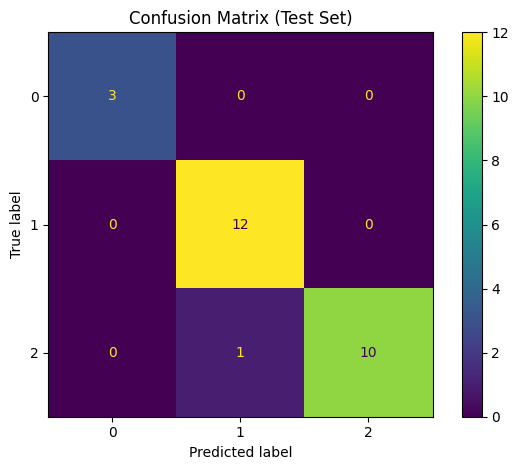

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      0.923     1.000     0.960        12
           2      1.000     0.909     0.952        11

    accuracy                          0.962        26
   macro avg      0.974     0.970     0.971        26
weighted avg      0.964     0.962     0.961        26



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# all_true, all_preds must already exist from your test evaluation
cm = confusion_matrix(all_true, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

print(classification_report(all_true, all_preds, digits=3))
